# __Classifying Dark Matter Substructure using Distillable Visual Transformer__

In [1]:
# !pip -q install vit_pytorch linformer
# !pip -q install split-folders

## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
from os import listdir
from os.path import join
import random
import zipfile
import logging
import time
import copy
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import (RandomRotation, RandomCrop,
                                    Pad, Resize, RandomAffine,
                                    ToTensor, Compose, RandomPerspective)
from tqdm.notebook import tqdm
import splitfolders
from sklearn.metrics import roc_curve, auc, confusion_matrix

from torchvision.models import resnet50, resnet18
from vit_pytorch.efficient import ViT
from vit_pytorch.distill import DistillableViT, DistillWrapper
from equivariance_net import Equivariant_Network
from torchinfo import summary


## __Make required folders for data and models__

In [3]:
# check if the directory for data exists else make it
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

## __Download data__

In [4]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/lenses.tgz'):
    url = "https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"
    output = "data/lenses.tgz"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

File exists


## __Extract data__
Check if the compressed data file is already extracted else extract data, and create the train-test split (0.9:0.1). <br>

The data folder looks like: 

```bash
lenses
├── train
│   ├── no_sub
│   └── sub
└── val
    ├── no_sub
    └── sub
```

In [5]:
# initialize the data directory name  
data_dir = 'data/lenses'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('tar xf data/lenses.tgz --directory data ; mv data/lenses data/lenses_raw')
    splitfolders.ratio('data/lenses_raw', output="data/lenses", seed=1337, ratio=(.9, 0.1))
    os.system('rm -r data/lenses_raw') 

Extracted folder exists


In [6]:
print(f"Torch: {torch.__version__}")

Torch: 1.6.0


## __Set Config and Hyperparameters__

In [7]:
# Data setting
n_classes = 2
img_size = 224

# Training parameters
batch_size = 128
epochs = 60
lr = 1e-3 # 5e-5

# optimizer parameters
weight_decay = 0 # 1e-7
amsgrad = True
gamma = 0.5
step_size_opt = 20 # step si 
use_lr_schedule = True

seed = 42 # fixing seed for repeatability
use_cuda = True # Using CUDA
cuda_idx = 0 # idx of CUDA device to be used

data_dir = 'data/lenses'

In [8]:
def seed_everything(seed):
    """Fixing various seeds

    Args:
        seed (int): any seed number

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

#### __Select CUDA device for training__

In [9]:
def get_device(use_cuda=True, cuda_idx=0):
    """Get the CUDA device

    Args:
        use_cuda (Bool): To used CUDA or not
        cuda_idx (int): index of CUDA device 
    
    Returns:
        device: CUDA device(s) being used 
    """

    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [10]:
device = get_device(use_cuda, cuda_idx)

Using device = cuda:0


#### __Logger to save the results__

In [11]:
def init_logging_handler(log_dir, current_time, extra=''):
    """Initializes the handler for logger. Create the logger directory if it doest exists. 
        Define the format of logging
        DEBUG logging level being used

    Args:
        log_dir (str): Logger directory
        current_time (str): time from logging to begin  
        extra (str): Space for adding extra info in .txt file
    
    """
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(os.path.join(log_dir, current_time)):
        os.makedirs(os.path.join(log_dir, current_time))

    stderr_handler = logging.StreamHandler()
    file_handler = logging.FileHandler('{}/{}/log_{}.txt'.format(
        log_dir, current_time, current_time + extra))
    logging.basicConfig(handlers=[stderr_handler, file_handler])
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
logging.getLogger('matplotlib.font_manager').disabled = True

In [12]:
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = 'logger'
init_logging_handler(log_dir, current_time)

## Define model location and name

In [13]:
os.makedirs("model", exist_ok=True)
PATH = os.path.join("model", f"DistillableViT_{current_time}.pt")

## Load Data

In [14]:
os.makedirs('data', exist_ok=True)

In [15]:
# images are padded to have shape 129x129.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

##### __Transforms__: Image is first randomaly cropped to have a size $128 \times 128$. It is then padded to increase the size to $129 \times 129$. Further, the image is resized to $387 \times 387$, randomly rotated and resized back to $224 \times 224$.

In [16]:
transform_train = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    resize1,
    RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
    # RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
    # RandomPerspective(distortion_scale=0.3, p=0.1),
    resize2,
    togray,
    totensor,
])
transform_test = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    togray,
    totensor,
])

In [17]:
class CustomDataset(Dataset):
    """Create custom dataset for the given data

    """

    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test', 'val']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        elif mode == "test":
            self.root_dir = self.root_dir+"/test"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir)
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = Image.open(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [18]:
trainset = CustomDataset(data_dir,'train',transform=transform_train)
valset = CustomDataset(data_dir,'val',transform=transform_test)
print(trainset[12][0].size())

torch.Size([1, 129, 129])


In [19]:
train_loader = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

#### __Visualize image samples__

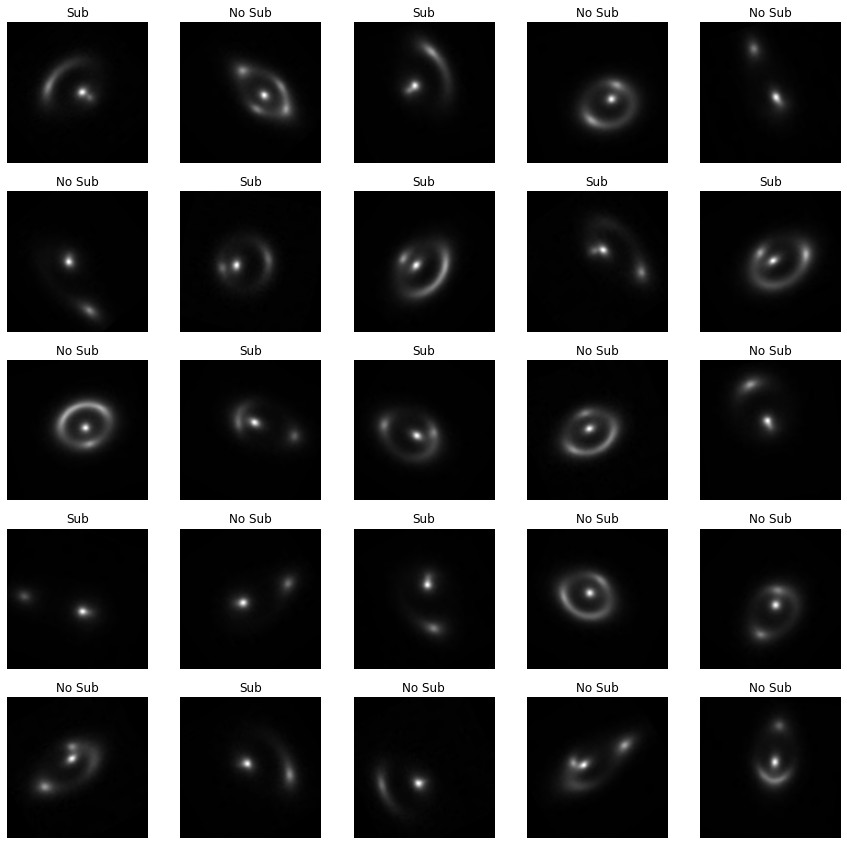

In [20]:
labels_map = {0: 'No Sub',1:'Sub'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # im = transforms.ToPILImage()(img)
    im = img.squeeze()
    plt.imshow(im, cmap='gray')
plt.show()

In [21]:
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(valset)}")

Train Data: 9000
Val Data: 1000


## DistillableViT

In [22]:
teacher = Equivariant_Network(n_classes=3, sym_group = 'Circular', N = 4)

TEACHER_PATH = 'model/cnn_state_dict_model.pt'
teacher.load_state_dict(torch.load(TEACHER_PATH))
for param in teacher.parameters():
    param.requires_grad = False   

# Fully Connected
teacher.fully_net = torch.nn.Sequential(
    torch.nn.Linear(43264, 32),
    torch.nn.BatchNorm1d(32),
    torch.nn.ELU(inplace=True),
    torch.nn.Linear(32, n_classes),
).to(device)


##### in_type: ##### [4-Rotations: {irrep_0}]


In [23]:
v = DistillableViT(
    image_size=129,
    patch_size=43, # change
    num_classes=2,
    dim = 32,# 64 1024
    channels=1,
    depth = 1,
    heads = 3,
    mlp_dim = 1024, # 2048
    # dropout = 0.1,
    # emb_dropout = 0.1
).to(device)

distiller = DistillWrapper(
    student = v,
    teacher = teacher,
    temperature = 6,           # temperature of distillation (3)
    alpha = 0.5,               # default: 0.5 trade between main loss and distillation loss
    hard = False               # whether to use soft or hard distillation
).to(device)

summary(v, input_size=(batch_size, 1, 129, 129))


Layer (type:depth-idx)                             Output Shape              Param #
DistillableViT                                     --                        --
├─Transformer: 1                                   --                        --
│    └─ModuleList: 2-1                             --                        --
│    │    └─ModuleList: 3-1                        --                        91,328
├─Sequential: 1-1                                  [128, 9, 32]              --
│    └─Rearrange: 2-2                              [128, 9, 1849]            --
│    └─Linear: 2-3                                 [128, 9, 32]              59,200
├─Dropout: 1-2                                     [128, 10, 32]             --
├─Transformer: 1-3                                 [128, 10, 32]             --
├─Identity: 1-4                                    [128, 32]                 --
├─Sequential: 1-5                                  [128, 2]                  --
│    └─LayerNorm: 2-4      

### Training

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(v.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay, amsgrad=amsgrad)
# scheduler
scheduler_plateau = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, threshold=0.0000001, verbose=True)
scheduler_step = StepLR(optimizer, step_size=step_size_opt, gamma=gamma)

In [25]:
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    tr_loss_epoch = []
    running_loss = 0


    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # output = v(data)
        loss = distiller(data, label)
        epoch_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # running_loss += loss.item() * data.size(0) # epoch_loss = running_loss / dataset_sizes[phase]
    epoch_loss = epoch_loss / len(train_loader)
    # all_train_loss.append(np.asarray(tr_loss_epoch))

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = v(data)
            val_loss = distiller(data, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc 
            epoch_val_loss += val_loss 
        epoch_val_accuracy =epoch_val_accuracy / len(valid_loader)
        epoch_val_loss =epoch_val_loss / len(valid_loader)
    
    all_val_loss.append(np.asarray(epoch_val_loss.item()))
    all_val_accuracy.append(epoch_val_accuracy.item()*100)
    logging.debug(        
        f"Epoch : {epoch+1} - LR {optimizer.param_groups[0]['lr']:.8f} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    if use_lr_schedule:
        # scheduler_plateau.step(epoch_loss) # ReduceLROnPlateau
        scheduler_step.step() # StepLR

    
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(v)  
        torch.save(best_model.state_dict(), PATH)

DEBUG:root:Epoch : 1 - LR 0.00100000 - loss : 0.3798 - val_loss : 0.3686 - val_acc: 0.5007



DEBUG:root:Epoch : 2 - LR 0.00100000 - loss : 0.3692 - val_loss : 0.3661 - val_acc: 0.5349



DEBUG:root:Epoch : 3 - LR 0.00100000 - loss : 0.3684 - val_loss : 0.3664 - val_acc: 0.5505



DEBUG:root:Epoch : 4 - LR 0.00100000 - loss : 0.3665 - val_loss : 0.3693 - val_acc: 0.5166



DEBUG:root:Epoch : 5 - LR 0.00100000 - loss : 0.3640 - val_loss : 0.3758 - val_acc: 0.4993



DEBUG:root:Epoch : 6 - LR 0.00100000 - loss : 0.3628 - val_loss : 0.3617 - val_acc: 0.5527



DEBUG:root:Epoch : 7 - LR 0.00100000 - loss : 0.3561 - val_loss : 0.3448 - val_acc: 0.6208



DEBUG:root:Epoch : 8 - LR 0.00100000 - loss : 0.3519 - val_loss : 0.3425 - val_acc: 0.6144



DEBUG:root:Epoch : 9 - LR 0.00050000 - loss : 0.3403 - val_loss : 0.3177 - val_acc: 0.6599



DEBUG:root:Epoch : 10 - LR 0.00050000 - loss : 0.3280 - val_loss : 0.3150 - val_acc: 0.6433



DEBUG:root:Epoch : 11 - LR 0.00050000 - loss : 0.3156 - val_loss : 0.3067 - val_acc: 0.6784



DEBUG:root:Epoch : 12 - LR 0.00050000 - loss : 0.3091 - val_loss : 0.3073 - val_acc: 0.6846



DEBUG:root:Epoch : 13 - LR 0.00050000 - loss : 0.3086 - val_loss : 0.2826 - val_acc: 0.7086



DEBUG:root:Epoch : 14 - LR 0.00050000 - loss : 0.3033 - val_loss : 0.3040 - val_acc: 0.6513



DEBUG:root:Epoch : 15 - LR 0.00050000 - loss : 0.2962 - val_loss : 0.2745 - val_acc: 0.7056



DEBUG:root:Epoch : 16 - LR 0.00050000 - loss : 0.2845 - val_loss : 0.2648 - val_acc: 0.7273



DEBUG:root:Epoch : 17 - LR 0.00025000 - loss : 0.2801 - val_loss : 0.2665 - val_acc: 0.7214



DEBUG:root:Epoch : 18 - LR 0.00025000 - loss : 0.2771 - val_loss : 0.2666 - val_acc: 0.7191



DEBUG:root:Epoch : 19 - LR 0.00025000 - loss : 0.2746 - val_loss : 0.2586 - val_acc: 0.7139



DEBUG:root:Epoch : 20 - LR 0.00025000 - loss : 0.2746 - val_loss : 0.2719 - val_acc: 0.7312



DEBUG:root:Epoch : 21 - LR 0.00025000 - loss : 0.2723 - val_loss : 0.2560 - val_acc: 0.7247



DEBUG:root:Epoch : 22 - LR 0.00025000 - loss : 0.2712 - val_loss : 0.2488 - val_acc: 0.7477



DEBUG:root:Epoch : 23 - LR 0.00025000 - loss : 0.2620 - val_loss : 0.2516 - val_acc: 0.7451



DEBUG:root:Epoch : 24 - LR 0.00025000 - loss : 0.2713 - val_loss : 0.2633 - val_acc: 0.7222



DEBUG:root:Epoch : 25 - LR 0.00012500 - loss : 0.2639 - val_loss : 0.2569 - val_acc: 0.7433



DEBUG:root:Epoch : 26 - LR 0.00012500 - loss : 0.2576 - val_loss : 0.2467 - val_acc: 0.7305



DEBUG:root:Epoch : 27 - LR 0.00012500 - loss : 0.2583 - val_loss : 0.2439 - val_acc: 0.7559



DEBUG:root:Epoch : 28 - LR 0.00012500 - loss : 0.2594 - val_loss : 0.2524 - val_acc: 0.7382



DEBUG:root:Epoch : 29 - LR 0.00012500 - loss : 0.2567 - val_loss : 0.2427 - val_acc: 0.7447



DEBUG:root:Epoch : 30 - LR 0.00012500 - loss : 0.2588 - val_loss : 0.2457 - val_acc: 0.7389



DEBUG:root:Epoch : 31 - LR 0.00012500 - loss : 0.2613 - val_loss : 0.2671 - val_acc: 0.7357



DEBUG:root:Epoch : 32 - LR 0.00012500 - loss : 0.2533 - val_loss : 0.2400 - val_acc: 0.7521



DEBUG:root:Epoch : 33 - LR 0.00006250 - loss : 0.2519 - val_loss : 0.2500 - val_acc: 0.7423



DEBUG:root:Epoch : 34 - LR 0.00006250 - loss : 0.2540 - val_loss : 0.2464 - val_acc: 0.7420



DEBUG:root:Epoch : 35 - LR 0.00006250 - loss : 0.2538 - val_loss : 0.2450 - val_acc: 0.7361



DEBUG:root:Epoch : 36 - LR 0.00006250 - loss : 0.2528 - val_loss : 0.2423 - val_acc: 0.7423



DEBUG:root:Epoch : 37 - LR 0.00006250 - loss : 0.2515 - val_loss : 0.2465 - val_acc: 0.7522



DEBUG:root:Epoch : 38 - LR 0.00006250 - loss : 0.2481 - val_loss : 0.2485 - val_acc: 0.7348



DEBUG:root:Epoch : 39 - LR 0.00006250 - loss : 0.2484 - val_loss : 0.2442 - val_acc: 0.7456



DEBUG:root:Epoch : 40 - LR 0.00006250 - loss : 0.2497 - val_loss : 0.2349 - val_acc: 0.7456



DEBUG:root:Epoch : 41 - LR 0.00003125 - loss : 0.2507 - val_loss : 0.2476 - val_acc: 0.7145



DEBUG:root:Epoch : 42 - LR 0.00003125 - loss : 0.2531 - val_loss : 0.2434 - val_acc: 0.7651



DEBUG:root:Epoch : 43 - LR 0.00003125 - loss : 0.2470 - val_loss : 0.2343 - val_acc: 0.7386



DEBUG:root:Epoch : 44 - LR 0.00003125 - loss : 0.2544 - val_loss : 0.2437 - val_acc: 0.7447



DEBUG:root:Epoch : 45 - LR 0.00003125 - loss : 0.2483 - val_loss : 0.2426 - val_acc: 0.7604



DEBUG:root:Epoch : 46 - LR 0.00003125 - loss : 0.2478 - val_loss : 0.2365 - val_acc: 0.7512



KeyboardInterrupt: 

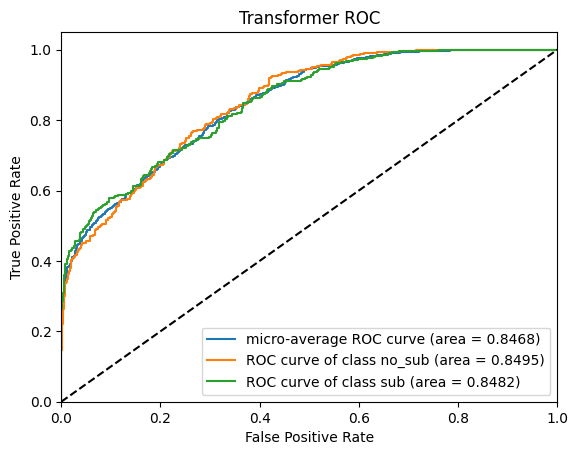

In [26]:
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

correct = 0
with torch.no_grad():
    best_model.eval()
    for i, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        y = best_model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(n_classes,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in valset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC')
plt.legend(loc="lower right")
plt.show()

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f26752631c0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f26752631c0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


Confusion matrix, without normalization


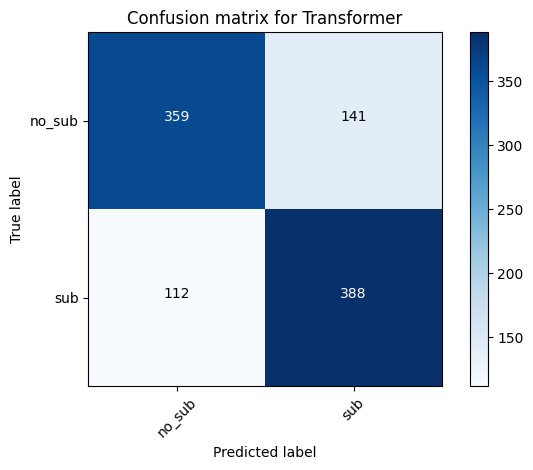

In [28]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[inv_map[0], inv_map[1]],title='Confusion matrix for Transformer')